# Fit for the $\Gamma$ GP values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz
import theano.tensor as tt
import pandas as pd
import mystyle as ms
from astropy.io import ascii
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
mal = pd.read_csv('../../data/malatium.csv', index_col=0)

In [3]:
cop = pd.read_csv('../../data/copper.csv',index_col=0)

Lets test on a single target first...

In [4]:
kic = 3632418

In [5]:
n0 = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].n.values
n1 = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].n.values
n2 = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].n.values

widths = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].Width.values
e_widths = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].e_Width.values
l0s = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].Freq.values

In [6]:
m_ = .4
c_ = .5
rho_ = 0.1
L_ = 0.3
fs = np.array(l0s)
fs -= fs.min()
nf = fs/fs.max()
nf_ = nf[:, None]

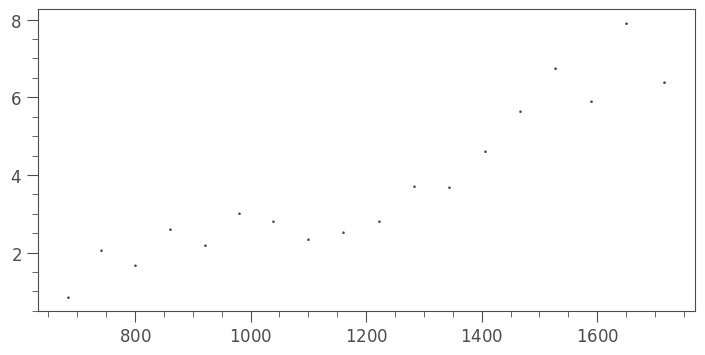

In [7]:
with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    ax.errorbar(l0s, widths, xerr=e_widths, fmt='^',label='0')

# Let's build the model

In [19]:
pm_model = pm.Model()

with pm_model:   
    m = pm.Normal('m', m_, 10.) 
    c = pm.Normal('c', c_, 10.)
    rho = pm.Normal('rho', rho_, 0.1) 
    ls = pm.Normal('ls', L_, 0.1)
    
    mu = pm.gp.mean.Linear(coeffs=m, intercept=c)
    cov = tt.sqr(rho) * pm.gp.cov.ExpQuad(1, ls=ls)     

    gp = pm.gp.Latent(cov_func = cov, mean_func=mu)    
    lng = gp.prior('lng', X=nf_)

    g0 = pm.Deterministic('g0', tt.exp(lng))
    
    pm.Normal('like0', g0, e_widths, observed=widths)  

In [20]:
init = 2500
with pm_model:
    trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lng_rotated_, ls, rho, c, m]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:54<00:00, 87.47draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
from pymc3.gp.util import plot_gp_dist

nflin = np.linspace(nf.min(), nf.max(), 100)
fslin = np.linspace(fs.min(), fs.max(), 100) + l0s.min()
mulin = nflin * np.median(trace['m']) + np.median(trace['c'])

with pm_model:
    f_pred = gp.conditional("f_pred", nflin[:,None])
    expf_pred = pm.Deterministic('expf_pred', tt.exp(f_pred))
    pred_samples = pm.sample_posterior_predictive(trace, vars=[expf_pred], samples=1000)

100%|██████████| 1000/1000 [00:19<00:00, 50.72it/s]


In [22]:
import lightkurve as lk

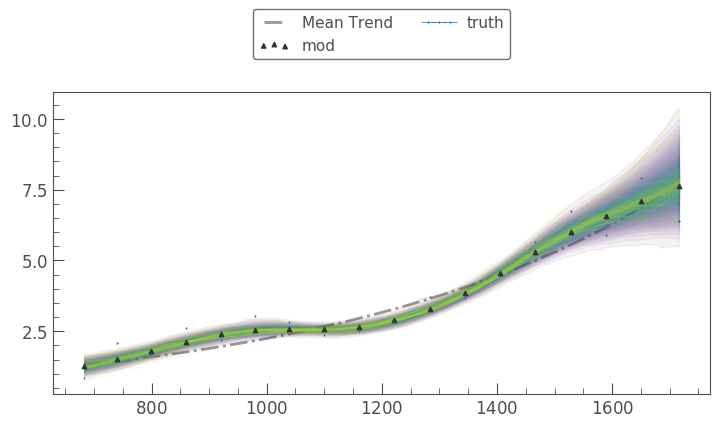

In [23]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    plot_gp_dist(ax, pred_samples['expf_pred'], fslin, palette='viridis', fill_alpha=.05)

    ax.plot(fslin, np.exp(mulin), label='Mean Trend', lw=2, ls='-.', alpha=.5, zorder=0)

    ax.errorbar(l0s, widths, xerr=e_widths, fmt='|', label='truth',zorder=5)
    
    ax.scatter(l0s, np.median(trace['g0'],axis=0), marker='^', label='mod', s=10,zorder=5)     
     
    
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.3))    

Lets just make this aligns with the literature value before continuing...

I'll check the small separation and epsilon areughly in the right ballpark, but not to within the errors, because we're not treating the very obvious glitches.

# Lets run on the whole sample!

In [26]:
bendalloy = pd.DataFrame()
bendalloy['KIC'] = mal.KIC.copy()
bendalloy['m'] = np.nan
bendalloy['m_e'] = np.nan
bendalloy['c'] = np.nan
bendalloy['c_e'] = np.nan
bendalloy['rho'] = np.nan
bendalloy['rho_e'] = np.nan
bendalloy['L'] = np.nan
bendalloy['L_e'] = np.nan
bendalloy.head(1)

,KIC,m,m_e,c,c_e,rho,rho_e,L,L_e
0,1435467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
repeat = False
if not repeat:
    check = pd.read_csv('../../data/bendalloy.csv', index_col=0)
    kics = check[~np.isfinite(check.m)].KIC.values
    print('Starting at KIC: {}'.format(str(kics[0])))
elif repeat:
    kics = mal.KIC.values

for kic in kics:
    if all(cop.loc[cop.KIC == str(kic), 'source'] != 'L'):
        bendalloy.loc[bendalloy.KIC==kic, 'm'] = 1.
        bendalloy.loc[bendalloy.KIC==kic, 'c'] = .5
        bendalloy.loc[bendalloy.KIC==kic, 'rho'] = .1
        bendalloy.loc[bendalloy.KIC==kic, 'L'] = .3
        pass
    
    print('Running KIC: {}'.format(str(kic)))
    
    n0 = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].n.values
    n1 = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].n.values
    n2 = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].n.values

    widths = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].Width.values
    e_widths = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].e_Width.values
    l0s = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].Freq.values

    m_ = .4
    c_ = .5
    rho_ = 0.1
    L_ = 0.3
    fs = np.array(l0s)
    fs -= fs.min()
    nf = fs/fs.max()
    nf_ = nf[:, None]
    
    # Run the model
    init=2500
    pm_model = pm.Model()

    with pm_model:   
        m = pm.Normal('m', m_, 10.) 
        c = pm.Normal('c', c_, 10.)
        rho = pm.Normal('rho', rho_, 0.1) 
        ls = pm.Normal('ls', L_, 0.1)

        mu = pm.gp.mean.Linear(coeffs=m, intercept=c)
        cov = tt.sqr(rho) * pm.gp.cov.ExpQuad(1, ls=ls)     

        gp = pm.gp.Latent(cov_func = cov, mean_func=mu)    
        lng = gp.prior('lng', X=nf_)

        g0 = pm.Deterministic('g0', tt.exp(lng))

        pm.Normal('like0', g0, e_widths, observed=widths)  

        
    init = 2500
    try:
        with pm_model:
            trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))
    except ValueError:
        bendalloy.loc[bendalloy.KIC==kic, 'm'] = 1.
        bendalloy.loc[bendalloy.KIC==kic, 'c'] = .5
        bendalloy.loc[bendalloy.KIC==kic, 'rho'] = .1
        bendalloy.loc[bendalloy.KIC==kic, 'L'] = .3
            
            
    from pymc3.gp.util import plot_gp_dist

    nflin = np.linspace(nf.min(), nf.max(), 100)
    fslin = np.linspace(fs.min(), fs.max(), 100) + l0s.min()
    mulin = nflin * np.median(trace['m']) + np.median(trace['c'])

    with pm_model:
        f_pred = gp.conditional("f_pred", nflin[:,None])
        expf_pred = pm.Deterministic('expf_pred', tt.exp(f_pred))
        pred_samples = pm.sample_posterior_predictive(trace, vars=[expf_pred], samples=1000)

    import lightkurve as lk

    with plt.style.context(lk.MPLSTYLE):
        fig, ax = plt.subplots()
        plot_gp_dist(ax, pred_samples['expf_pred'], fslin, palette='viridis', fill_alpha=.05)

        ax.plot(fslin, np.exp(mulin), label='Mean Trend', lw=2, ls='-.', alpha=.5, zorder=0)

        ax.errorbar(l0s, widths, xerr=e_widths, fmt='|', label='truth',zorder=5)

        ax.scatter(l0s, np.median(trace['g0'],axis=0), marker='^', label='mod', s=10,zorder=5)     


        ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.3))    
        plt.show()
        
    # Add the output to the array
    bendalloy.loc[bendalloy.KIC==kic, 'm'] = np.median(trace['m'])
    bendalloy.loc[bendalloy.KIC==kic, 'm_e'] = np.std(trace['m'])
    bendalloy.loc[bendalloy.KIC==kic, 'c'] = np.median(trace['c'])
    bendalloy.loc[bendalloy.KIC==kic, 'c_e'] = np.std(trace['c'])
    bendalloy.loc[bendalloy.KIC==kic, 'rho'] = np.median(trace['rho'])
    bendalloy.loc[bendalloy.KIC==kic, 'rho_e'] = np.std(trace['rho'])
    bendalloy.loc[bendalloy.KIC==kic, 'L'] = np.median(trace['ls'])
    bendalloy.loc[bendalloy.KIC==kic, 'e_L'] = np.std(trace['ls'])    
    
    bendalloy.to_csv('../../data/bendalloy.csv')

Starting at KIC: 3425851
Running KIC: 3425851


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Incompatible shapes for gemv (beta * y + alpha * dot(A, x)). y: (7,), A: (7, 7), x: (19,) 
Apply node that caused the error: Gemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, Cholesky{lower=True, destructive=False, on_error='raise'}.0, lng_rotated_, TensorConstant{0.0})
Toposort index: 20
Inputs types: [TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, scalar)]
Inputs shapes: [(7,), (), (7, 7), (19,), ()]
Inputs strides: [(8,), (), (8, 56), (8,), ()]
Inputs values: ['not shown', array(1.), 'not shown', 'not shown', array(0.)]
Outputs clients: [[Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}(Cholesky{lower=True, destructive=False, on_error='raise'}.0, Gemv{inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/oliver/.local/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-bf7e070f62df>", line 50, in <module>
    lng = gp.prior('lng', X=nf_)
  File "/home/oliver/.local/lib/python3.7/site-packages/pymc3/gp/gp.py", line 145, in prior
    f = self._build_prior(name, X, reparameterize, **kwargs)
  File "/home/oliver/.local/lib/python3.7/site-packages/pymc3/gp/gp.py", line 115, in _build_prior
    f = pm.Deterministic(name, mu + cholesky(cov).dot(v))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

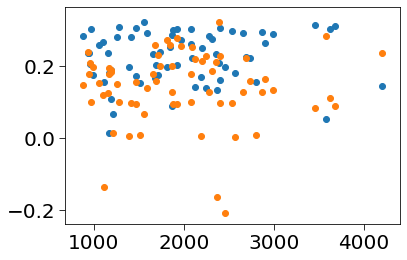

In [38]:
plt.scatter(mal.numax, bendalloy.L)
plt.scatter(mal.numax, bendalloy.rho)

In [ ]:
bendalloy.to_csv('../../data/bendalloy.csv')